Using device: mps
Loaded features: torch.Size([2000, 32, 2048])
Loaded labels: torch.Size([2000])
LSTMClassifier(
  (lstm): LSTM(2048, 768, num_layers=2, batch_first=True, dropout=0.5, bidirectional=True)
  (attn_pool): AttentionPool(
    (attn): Sequential(
      (0): Linear(in_features=1536, out_features=768, bias=True)
      (1): Tanh()
      (2): Linear(in_features=768, out_features=1, bias=True)
    )
  )
  (dropout): Dropout(p=0.4, inplace=False)
  (batchnorm): BatchNorm1d(4608, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc): Sequential(
    (0): Linear(in_features=4608, out_features=768, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.4, inplace=False)
    (3): Linear(in_features=768, out_features=384, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.4, inplace=False)
    (6): Linear(in_features=384, out_features=2, bias=True)
  )
)
Epoch [1/30] | Loss: 0.1516 | Val Acc: 0.7667
Epoch [2/30] | Loss: 0.1396 | Val Acc: 0.7967
Epoch [3/30] | Loss: 0.1242 | Val

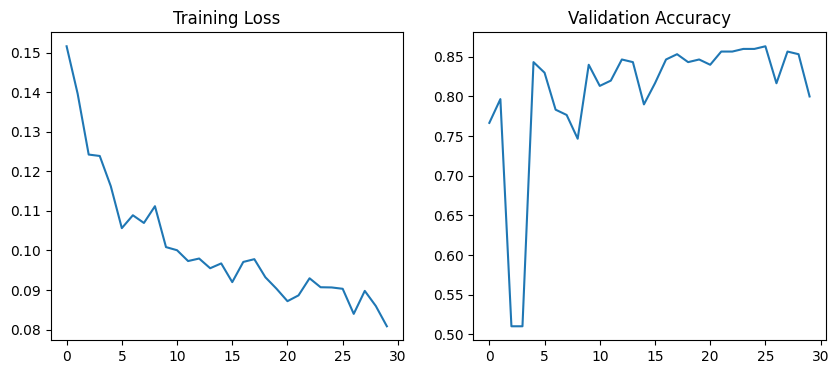

In [ ]:
# LSTM Deepfake Classifier 

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, random_split
import matplotlib.pyplot as plt

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

features = torch.load("all_features.pt")
labels = torch.load("all_labels.pt")

print("Loaded features:", features.shape)
print("Loaded labels:", labels.shape)

dataset = TensorDataset(features, labels)
train_size = int(0.7 * len(dataset))
val_size   = int(0.15 * len(dataset))
test_size  = len(dataset) - train_size - val_size

train_data, val_data, test_data = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_data, batch_size=8, shuffle=True)
val_loader   = DataLoader(val_data, batch_size=8)
test_loader  = DataLoader(test_data, batch_size=8)

# Optional: Focal Loss
class FocalLoss(nn.Module):
    def __init__(self, gamma=2.0, weight=None, reduction='mean'):
        super().__init__()
        self.gamma = gamma
        self.weight = weight
        self.reduction = reduction

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, weight=self.weight, reduction='none')
        pt = torch.exp(-ce_loss)
        loss = ((1 - pt) ** self.gamma) * ce_loss

        return loss.mean() if self.reduction == 'mean' else loss.sum()

class AttentionPool(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.attn = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, 1)
        )

    def forward(self, lstm_out):
        scores = self.attn(lstm_out)               # [B, T, 1]
        weights = torch.softmax(scores, dim=1)     # [B, T, 1]
        context = (weights * lstm_out).sum(dim=1)  # [B, H*2]
        return context


class LSTMClassifier(nn.Module):
    def __init__(self, num_classes=2):
        super().__init__()
        hidden_dim = 768
        self.lstm = nn.LSTM(
            2048, hidden_dim, num_layers=2,
            batch_first=True, bidirectional=True, dropout=0.5
        )
        self.attn_pool = AttentionPool(hidden_dim)
        self.dropout = nn.Dropout(0.4)

        # Combine attn + avg + max → 3 * (H*2)
        combined_dim = hidden_dim * 2 * 3
        self.batchnorm = nn.BatchNorm1d(combined_dim)

        self.fc = nn.Sequential(
            nn.Linear(combined_dim, 768),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(768, 384),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(384, num_classes)
        )

    def forward(self, x):
        # x: [B, T, 2048]
        lstm_out, _ = self.lstm(x)  # [B, T, H*2]

        attn = self.attn_pool(lstm_out)            # [B, H*2]
        avg_pool = torch.mean(lstm_out, dim=1)     # [B, H*2]
        max_pool, _ = torch.max(lstm_out, dim=1)   # [B, H*2]

        combined = torch.cat([attn, avg_pool, max_pool], dim=1)  # [B, 3*H*2]
        combined = self.batchnorm(combined)
        combined = self.dropout(combined)

        return self.fc(combined)

model = LSTMClassifier().to(device)
print(model)

# Use FocalLoss or label-smoothing CrossEntropy
criterion = FocalLoss(gamma=2.0)
# criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

optimizer = torch.optim.AdamW(model.parameters(), lr=2e-4, weight_decay=1e-2)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3)

NUM_EPOCHS =30
train_losses, val_accuracies = [], []
best_val_acc = 0.0
best_model_state = None

for epoch in range(NUM_EPOCHS):
    model.train()
    total_loss = 0

    for X, y in train_loader:
        X, y = X.to(device), y.to(device)
        out = model(X)
        loss = criterion(out, y)
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)
        optimizer.step()
        total_loss += loss.item()

    avg_train_loss = total_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for X_val, y_val in val_loader:
            X_val, y_val = X_val.to(device), y_val.to(device)
            pred = model(X_val)
            _, y_pred = pred.max(1)
            correct += (y_pred == y_val).sum().item()
            total += y_val.size(0)

    val_acc = correct / total
    val_accuracies.append(val_acc)
    scheduler.step(val_acc)

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model_state = model.state_dict()
        torch.save(best_model_state, "best_lstm_model_final.pth")

    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}] | Loss: {avg_train_loss:.4f} | Val Acc: {val_acc:.4f}")

# Final Test Accuracy
model.load_state_dict(best_model_state)
model.eval()
correct, total = 0, 0
with torch.no_grad():
    for X_test, y_test in test_loader:
        X_test, y_test = X_test.to(device), y_test.to(device)
        output = model(X_test)
        _, y_pred = torch.max(output, 1)
        correct += (y_pred == y_test).sum().item()
        total += y_test.size(0)

print(f"🎯 Final Test Accuracy: {correct / total:.4f}")

# Plot
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss')
plt.title("Training Loss")
plt.subplot(1,2,2)
plt.plot(val_accuracies, label='Val Acc')
plt.title("Validation Accuracy")
plt.show()
